In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
import zuko
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
from sklearn.decomposition import IncrementalPCA
import sklearn.decomposition 
import os
import json


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetStrainFD
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *
from river.models.embedding.conv import EmbeddingConv1D,EmbeddingConv2D


# Make test data

In [3]:
config_path = "trained_models/glasnsf_conv1dconv2d"
with open(f"{config_path}/config.json", 'r') as f:
    config = json.load(f)

config_datagenerator = config['data_generator_parameters']
config_training = config['training_parameters']
config_flow = config['model_parameters']['flow']
config_embd_proj = config['model_parameters']['embedding_proj']
config_embd_noproj = config['model_parameters']['embedding_noproj']

In [4]:
detector_names = config_datagenerator['detector_names']

Ntest = 200
injection_parameters_test = generate_BNS_injection_parameters(Nsample = Ntest, **config_datagenerator)
data_generator_test = DataGeneratorBilbyFD(**config_datagenerator)


10:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [5]:
injection_parameters_test['dec']

array([ 1.31099997,  0.09438537, -0.34052337,  1.20372261, -0.52554963,
       -0.24594072,  0.15404557, -0.82718632,  0.03355805,  0.40460167,
        0.08932524, -0.26620763,  0.55808352, -0.06716013, -0.34119888,
       -0.48993714, -0.0324941 ,  0.93934514, -0.53114425, -0.90327438,
        0.55283432,  1.01982552,  0.25067184, -1.01562115, -0.67540382,
        0.20903528, -0.48505066,  0.25264287,  0.13123928,  0.32989103,
        0.24858384,  0.96282646,  0.72980137,  0.07686493, -0.59228035,
        0.03189466, -0.60300955, -0.283017  , -0.36480031,  0.47256308,
        0.00282827,  0.56740225,  0.02844234, -1.38570387, -1.22623146,
        0.22837948, -0.39493219, -0.97629816, -0.89157147,  0.76025175,
        0.01716893,  0.6356371 , -0.10969478, -0.32385603,  1.33046593,
       -0.65647104,  0.18121015, -0.61082431, -0.64647275,  1.44643215,
        0.25572794, -0.40189979, -0.12317192,  0.83707281, -0.15163916,
        0.33048184,  0.28509416,  0.27814021, -0.02485371,  0.33

In [6]:
data_generator_test.inject_signals(injection_parameters_test, Ntest)
data_generator_test.numpy_starins()

10:07 bilby WARNING : The injected signal has a duration in-band of 139.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 139.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 139.4s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 87.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 87.4s, but the data for detector L1 has a du

Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.5% done
Injecting 2-th signal, 1.0% done
Injecting 3-th signal, 1.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 141.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 141.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 141.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.7s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.7s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 165.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 165.3s, but the data for detector L1 has a dur

Injecting 4-th signal, 2.0% done
Injecting 5-th signal, 2.5% done
Injecting 6-th signal, 3.0% done
Injecting 7-th signal, 3.5% done
Injecting 8-th signal, 4.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 109.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.5s, but the data for detector L1 has a durat

Injecting 9-th signal, 4.5% done
Injecting 10-th signal, 5.0% done
Injecting 11-th signal, 5.5% done
Injecting 12-th signal, 6.0% done
Injecting 13-th signal, 6.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 70.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.4s, but the data for detector L1 has a durat

Injecting 14-th signal, 7.0% done
Injecting 15-th signal, 7.5% done
Injecting 16-th signal, 8.0% done
Injecting 17-th signal, 8.5% done
Injecting 18-th signal, 9.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 76.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 83.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 83.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 83.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.4s, but the data for detector L1 has a duration

Injecting 19-th signal, 9.5% done
Injecting 20-th signal, 10.0% done
Injecting 21-th signal, 10.5% done
Injecting 22-th signal, 11.0% done
Injecting 23-th signal, 11.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 98.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 98.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 98.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.4s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 112.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 112.9s, but the data for detector L1 has a durati

Injecting 24-th signal, 12.0% done
Injecting 25-th signal, 12.5% done
Injecting 26-th signal, 13.0% done
Injecting 27-th signal, 13.5% done
Injecting 28-th signal, 14.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 105.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 105.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 105.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 78.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 78.5s, but the data for detector L1 has a du

Injecting 29-th signal, 14.5% done
Injecting 30-th signal, 15.0% done
Injecting 31-th signal, 15.5% done
Injecting 32-th signal, 16.0% done
Injecting 33-th signal, 16.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 121.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 121.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 121.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 88.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 88.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 88.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 126.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 126.6s, but the data for detector L1 has a dur

Injecting 34-th signal, 17.0% done
Injecting 35-th signal, 17.5% done
Injecting 36-th signal, 18.0% done
Injecting 37-th signal, 18.5% done
Injecting 38-th signal, 19.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 77.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 116.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 116.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 116.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.5s, but the data for detector L1 has a durat

Injecting 39-th signal, 19.5% done
Injecting 40-th signal, 20.0% done
Injecting 41-th signal, 20.5% done
Injecting 42-th signal, 21.0% done
Injecting 43-th signal, 21.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 63.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.7s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.7s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 68.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 68.1s, but the data for detector L1 has a durat

Injecting 44-th signal, 22.0% done
Injecting 45-th signal, 22.5% done
Injecting 46-th signal, 23.0% done
Injecting 47-th signal, 23.5% done
Injecting 48-th signal, 24.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 134.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 134.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 134.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.9s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.9s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 72.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 72.6s, but the data for detector L1 has a durat

Injecting 49-th signal, 24.5% done
Injecting 50-th signal, 25.0% done
Injecting 51-th signal, 25.5% done
Injecting 52-th signal, 26.0% done
Injecting 53-th signal, 26.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 99.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.9s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.9s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 62.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 62.1s, but the data for detector L1 has a duration

Injecting 54-th signal, 27.0% done
Injecting 55-th signal, 27.5% done
Injecting 56-th signal, 28.0% done
Injecting 57-th signal, 28.5% done
Injecting 58-th signal, 29.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 71.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 117.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 117.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 117.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 157.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 157.8s, but the data for detector L1 has a dur

Injecting 59-th signal, 29.5% done
Injecting 60-th signal, 30.0% done
Injecting 61-th signal, 30.5% done
Injecting 62-th signal, 31.0% done
Injecting 63-th signal, 31.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 144.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 144.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 144.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 192.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 192.3s, but the data for detector L1 has a 

Injecting 64-th signal, 32.0% done
Injecting 65-th signal, 32.5% done
Injecting 66-th signal, 33.0% done
Injecting 67-th signal, 33.5% done
Injecting 68-th signal, 34.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 74.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 74.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 74.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 130.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 130.1s, but the data for detector L1 has a durati

Injecting 69-th signal, 34.5% done
Injecting 70-th signal, 35.0% done
Injecting 71-th signal, 35.5% done
Injecting 72-th signal, 36.0% done
Injecting 73-th signal, 36.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 69.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 69.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 69.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 164.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 164.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 164.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 127.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 127.6s, but the data for detector L1 has a dur

Injecting 74-th signal, 37.0% done
Injecting 75-th signal, 37.5% done
Injecting 76-th signal, 38.0% done
Injecting 77-th signal, 38.5% done
Injecting 78-th signal, 39.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 154.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 154.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 154.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 222.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 222.4s, but the data for detector L1 has a 

Injecting 79-th signal, 39.5% done
Injecting 80-th signal, 40.0% done
Injecting 81-th signal, 40.5% done
Injecting 82-th signal, 41.0% done
Injecting 83-th signal, 41.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 95.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 95.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 95.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 122.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 122.2s, but the data for detector L1 has a durati

Injecting 84-th signal, 42.0% done
Injecting 85-th signal, 42.5% done
Injecting 86-th signal, 43.0% done
Injecting 87-th signal, 43.5% done
Injecting 88-th signal, 44.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 103.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 103.9s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 103.9s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.7s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.7s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.6s, but the data for detector L1 has a durat

Injecting 89-th signal, 44.5% done
Injecting 90-th signal, 45.0% done
Injecting 91-th signal, 45.5% done
Injecting 92-th signal, 46.0% done
Injecting 93-th signal, 46.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 135.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 135.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 135.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 64.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 64.1s, but the data for detector L1 has a durat

Injecting 94-th signal, 47.0% done
Injecting 95-th signal, 47.5% done
Injecting 96-th signal, 48.0% done
Injecting 97-th signal, 48.5% done
Injecting 98-th signal, 49.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 169.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 169.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 169.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.9s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 65.9s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.7s, but the data for detector L1 has a durat

Injecting 99-th signal, 49.5% done
Injecting 100-th signal, 50.0% done
Injecting 101-th signal, 50.5% done
Injecting 102-th signal, 51.0% done
Injecting 103-th signal, 51.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 90.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 120.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 120.1s, but the data for detector L1 has a durati

Injecting 104-th signal, 52.0% done
Injecting 105-th signal, 52.5% done
Injecting 106-th signal, 53.0% done
Injecting 107-th signal, 53.5% done
Injecting 108-th signal, 54.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 68.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 68.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 68.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.4s, but the data for detector L1 has a durat

Injecting 109-th signal, 54.5% done
Injecting 110-th signal, 55.0% done
Injecting 111-th signal, 55.5% done
Injecting 112-th signal, 56.0% done
Injecting 113-th signal, 56.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 98.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 98.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 98.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 84.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 84.1s, but the data for detector L1 has a duration

Injecting 114-th signal, 57.0% done
Injecting 115-th signal, 57.5% done
Injecting 116-th signal, 58.0% done
Injecting 117-th signal, 58.5% done
Injecting 118-th signal, 59.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 80.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 80.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 80.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 107.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 107.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 107.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 79.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 79.8s, but the data for detector L1 has a durat

Injecting 119-th signal, 59.5% done
Injecting 120-th signal, 60.0% done
Injecting 121-th signal, 60.5% done
Injecting 122-th signal, 61.0% done
Injecting 123-th signal, 61.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 155.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 155.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 155.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 53.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 53.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 53.4s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 82.8s, but the data for detector L1 has a durat

Injecting 124-th signal, 62.0% done
Injecting 125-th signal, 62.5% done
Injecting 126-th signal, 63.0% done
Injecting 127-th signal, 63.5% done
Injecting 128-th signal, 64.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 126.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 126.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 126.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 50.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 50.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 50.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 101.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 101.6s, but the data for detector L1 has a dur

Injecting 129-th signal, 64.5% done
Injecting 130-th signal, 65.0% done
Injecting 131-th signal, 65.5% done
Injecting 132-th signal, 66.0% done
Injecting 133-th signal, 66.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 73.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 73.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 73.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 66.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 66.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 66.4s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 80.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 80.1s, but the data for detector L1 has a duration

Injecting 134-th signal, 67.0% done
Injecting 135-th signal, 67.5% done
Injecting 136-th signal, 68.0% done
Injecting 137-th signal, 68.5% done
Injecting 138-th signal, 69.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 73.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 73.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 73.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.7s, but the data for detector L1 has a durati

Injecting 139-th signal, 69.5% done
Injecting 140-th signal, 70.0% done
Injecting 141-th signal, 70.5% done
Injecting 142-th signal, 71.0% done
Injecting 143-th signal, 71.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 108.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 108.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 128.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 128.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 128.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 105.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 105.6s, but the data for detector L1 has a 

Injecting 144-th signal, 72.0% done
Injecting 145-th signal, 72.5% done
Injecting 146-th signal, 73.0% done
Injecting 147-th signal, 73.5% done
Injecting 148-th signal, 74.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 114.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 70.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.7s, but the data for detector L1 has a dur

Injecting 149-th signal, 74.5% done
Injecting 150-th signal, 75.0% done
Injecting 151-th signal, 75.5% done
Injecting 152-th signal, 76.0% done
Injecting 153-th signal, 76.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 76.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.8s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.8s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 140.7s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 140.7s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 140.7s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 76.1s, but the data for detector L1 has a durat

Injecting 154-th signal, 77.0% done
Injecting 155-th signal, 77.5% done
Injecting 156-th signal, 78.0% done
Injecting 157-th signal, 78.5% done
Injecting 158-th signal, 79.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 71.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 71.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.6s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.6s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 57.6s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 114.3s, but the data for detector L1 has a durati

Injecting 159-th signal, 79.5% done
Injecting 160-th signal, 80.0% done
Injecting 161-th signal, 80.5% done
Injecting 162-th signal, 81.0% done
Injecting 163-th signal, 81.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 84.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 84.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 84.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 111.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 111.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 111.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 79.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 79.9s, but the data for detector L1 has a durat

Injecting 164-th signal, 82.0% done
Injecting 165-th signal, 82.5% done
Injecting 166-th signal, 83.0% done
Injecting 167-th signal, 83.5% done
Injecting 168-th signal, 84.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 96.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 96.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 96.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 133.2s, but the data for detector L1 has a durati

Injecting 169-th signal, 84.5% done
Injecting 170-th signal, 85.0% done
Injecting 171-th signal, 85.5% done
Injecting 172-th signal, 86.0% done
Injecting 173-th signal, 86.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 109.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 109.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 119.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 119.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 119.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 118.0s, but the data for detector L1 has a 

Injecting 174-th signal, 87.0% done
Injecting 175-th signal, 87.5% done
Injecting 176-th signal, 88.0% done
Injecting 177-th signal, 88.5% done
Injecting 178-th signal, 89.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 94.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 94.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 94.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.5s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 90.5s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.8s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 85.8s, but the data for detector L1 has a duration

Injecting 179-th signal, 89.5% done
Injecting 180-th signal, 90.0% done
Injecting 181-th signal, 90.5% done
Injecting 182-th signal, 91.0% done
Injecting 183-th signal, 91.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 93.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 93.4s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 142.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 142.9s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 142.9s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.3s, but the data for detector L1 has a durat

Injecting 184-th signal, 92.0% done
Injecting 185-th signal, 92.5% done
Injecting 186-th signal, 93.0% done
Injecting 187-th signal, 93.5% done
Injecting 188-th signal, 94.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 74.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 74.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 74.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 91.0s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 91.0s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 91.0s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.5s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 77.5s, but the data for detector L1 has a duration

Injecting 189-th signal, 94.5% done
Injecting 190-th signal, 95.0% done
Injecting 191-th signal, 95.5% done
Injecting 192-th signal, 96.0% done
Injecting 193-th signal, 96.5% done


10:07 bilby WARNING : The injected signal has a duration in-band of 188.2s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 188.2s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 188.2s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 63.1s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 102.9s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 102.9s, but the data for detector L1 has a dur

Injecting 194-th signal, 97.0% done
Injecting 195-th signal, 97.5% done
Injecting 196-th signal, 98.0% done
Injecting 197-th signal, 98.5% done
Injecting 198-th signal, 99.0% done


10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.3s, but the data for detector V1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.4s, but the data for detector H1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.4s, but the data for detector L1 has a duration of 32s
10:07 bilby WARNING : The injected signal has a duration in-band of 99.4s, but the data for detector V1 has a duration of 32s


Injecting 199-th signal, 99.5% done


In [7]:
dataset_test = DatasetStrainFD(data_dict=data_generator_test.data, parameter_names=PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)

In [8]:
#batch_size = 1
#test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

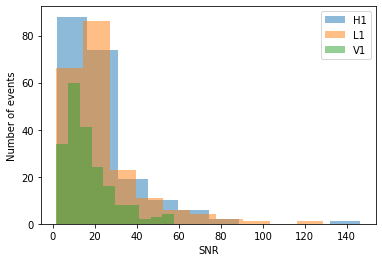

In [9]:

for key, values in data_generator_test.data['SNRs'].items():
    _ = plt.hist(values, label=key, alpha=0.5)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()

# Load model

In [10]:
ipca_path = config['model_parameters']['ipca_path']
ipca_gen = load_model(ipca_path)
n_components = ipca_gen.n_components

downsample_rate = config_embd_noproj['downsample_rate']
n_freq = dataset_test[0:2][1][:,:,::downsample_rate].shape[-1]
device='cuda:0'
embedding_proj = get_model(config_embd_proj).to(device)
embedding_noproj = get_model(config_embd_noproj).to(device)
flow = get_model(config_flow).to(device)

Model loaded from ../scripts/ipca_models/IPCA_BNSFD_10000to500_ExpUnwrap_fixtc.pickle


In [11]:
ckpt_dir = config['ckpt_dir']
ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [12]:

checkpoint = torch.load(ckpt_path)
start_epoch = checkpoint['epoch']
embedding_proj.load_state_dict(checkpoint['embd_proj_state_dict'])
embedding_noproj.load_state_dict(checkpoint['embd_noproj_state_dict'])
flow.load_state_dict(checkpoint['flow_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

KeyboardInterrupt: 

In [ ]:
#sample_list, loss_list = sample_zukoflow(flow, embedding_proj, embedding_noproj, dataset_test, detector_names, ipca_gen, device=device, Nsample=5000)
sample_list, loss_list = sample_glasflow(flow, embedding_proj, embedding_noproj, dataset_test, detector_names, ipca_gen, device=device, Nsample=5000,downsample_rate=downsample_rate)


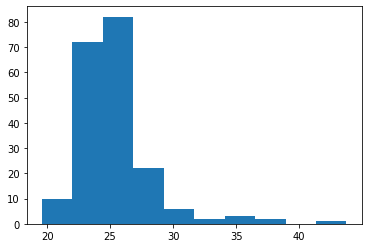

In [ ]:
_ = plt.hist(loss_list)

In [ ]:
sample_list.shape


torch.Size([200, 17, 5000])

In [ ]:
result_list = make_results(sample_list, data_generator_test.data['injection_parameters'], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)

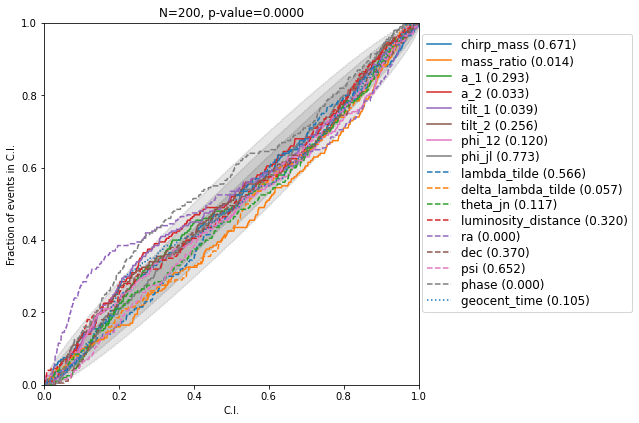

In [ ]:
#fig = bilby.core.result.make_pp_plot(result_list, filename=None, save=False, confidence_interval=[0.68, 0.95, 0.997])
fig = make_pp_plot(result_list, filename = f"{config_path}/pp_plot.png", save=True, confidence_interval=[0.68, 0.95, 0.997])

In [ ]:
result = result_list[0]

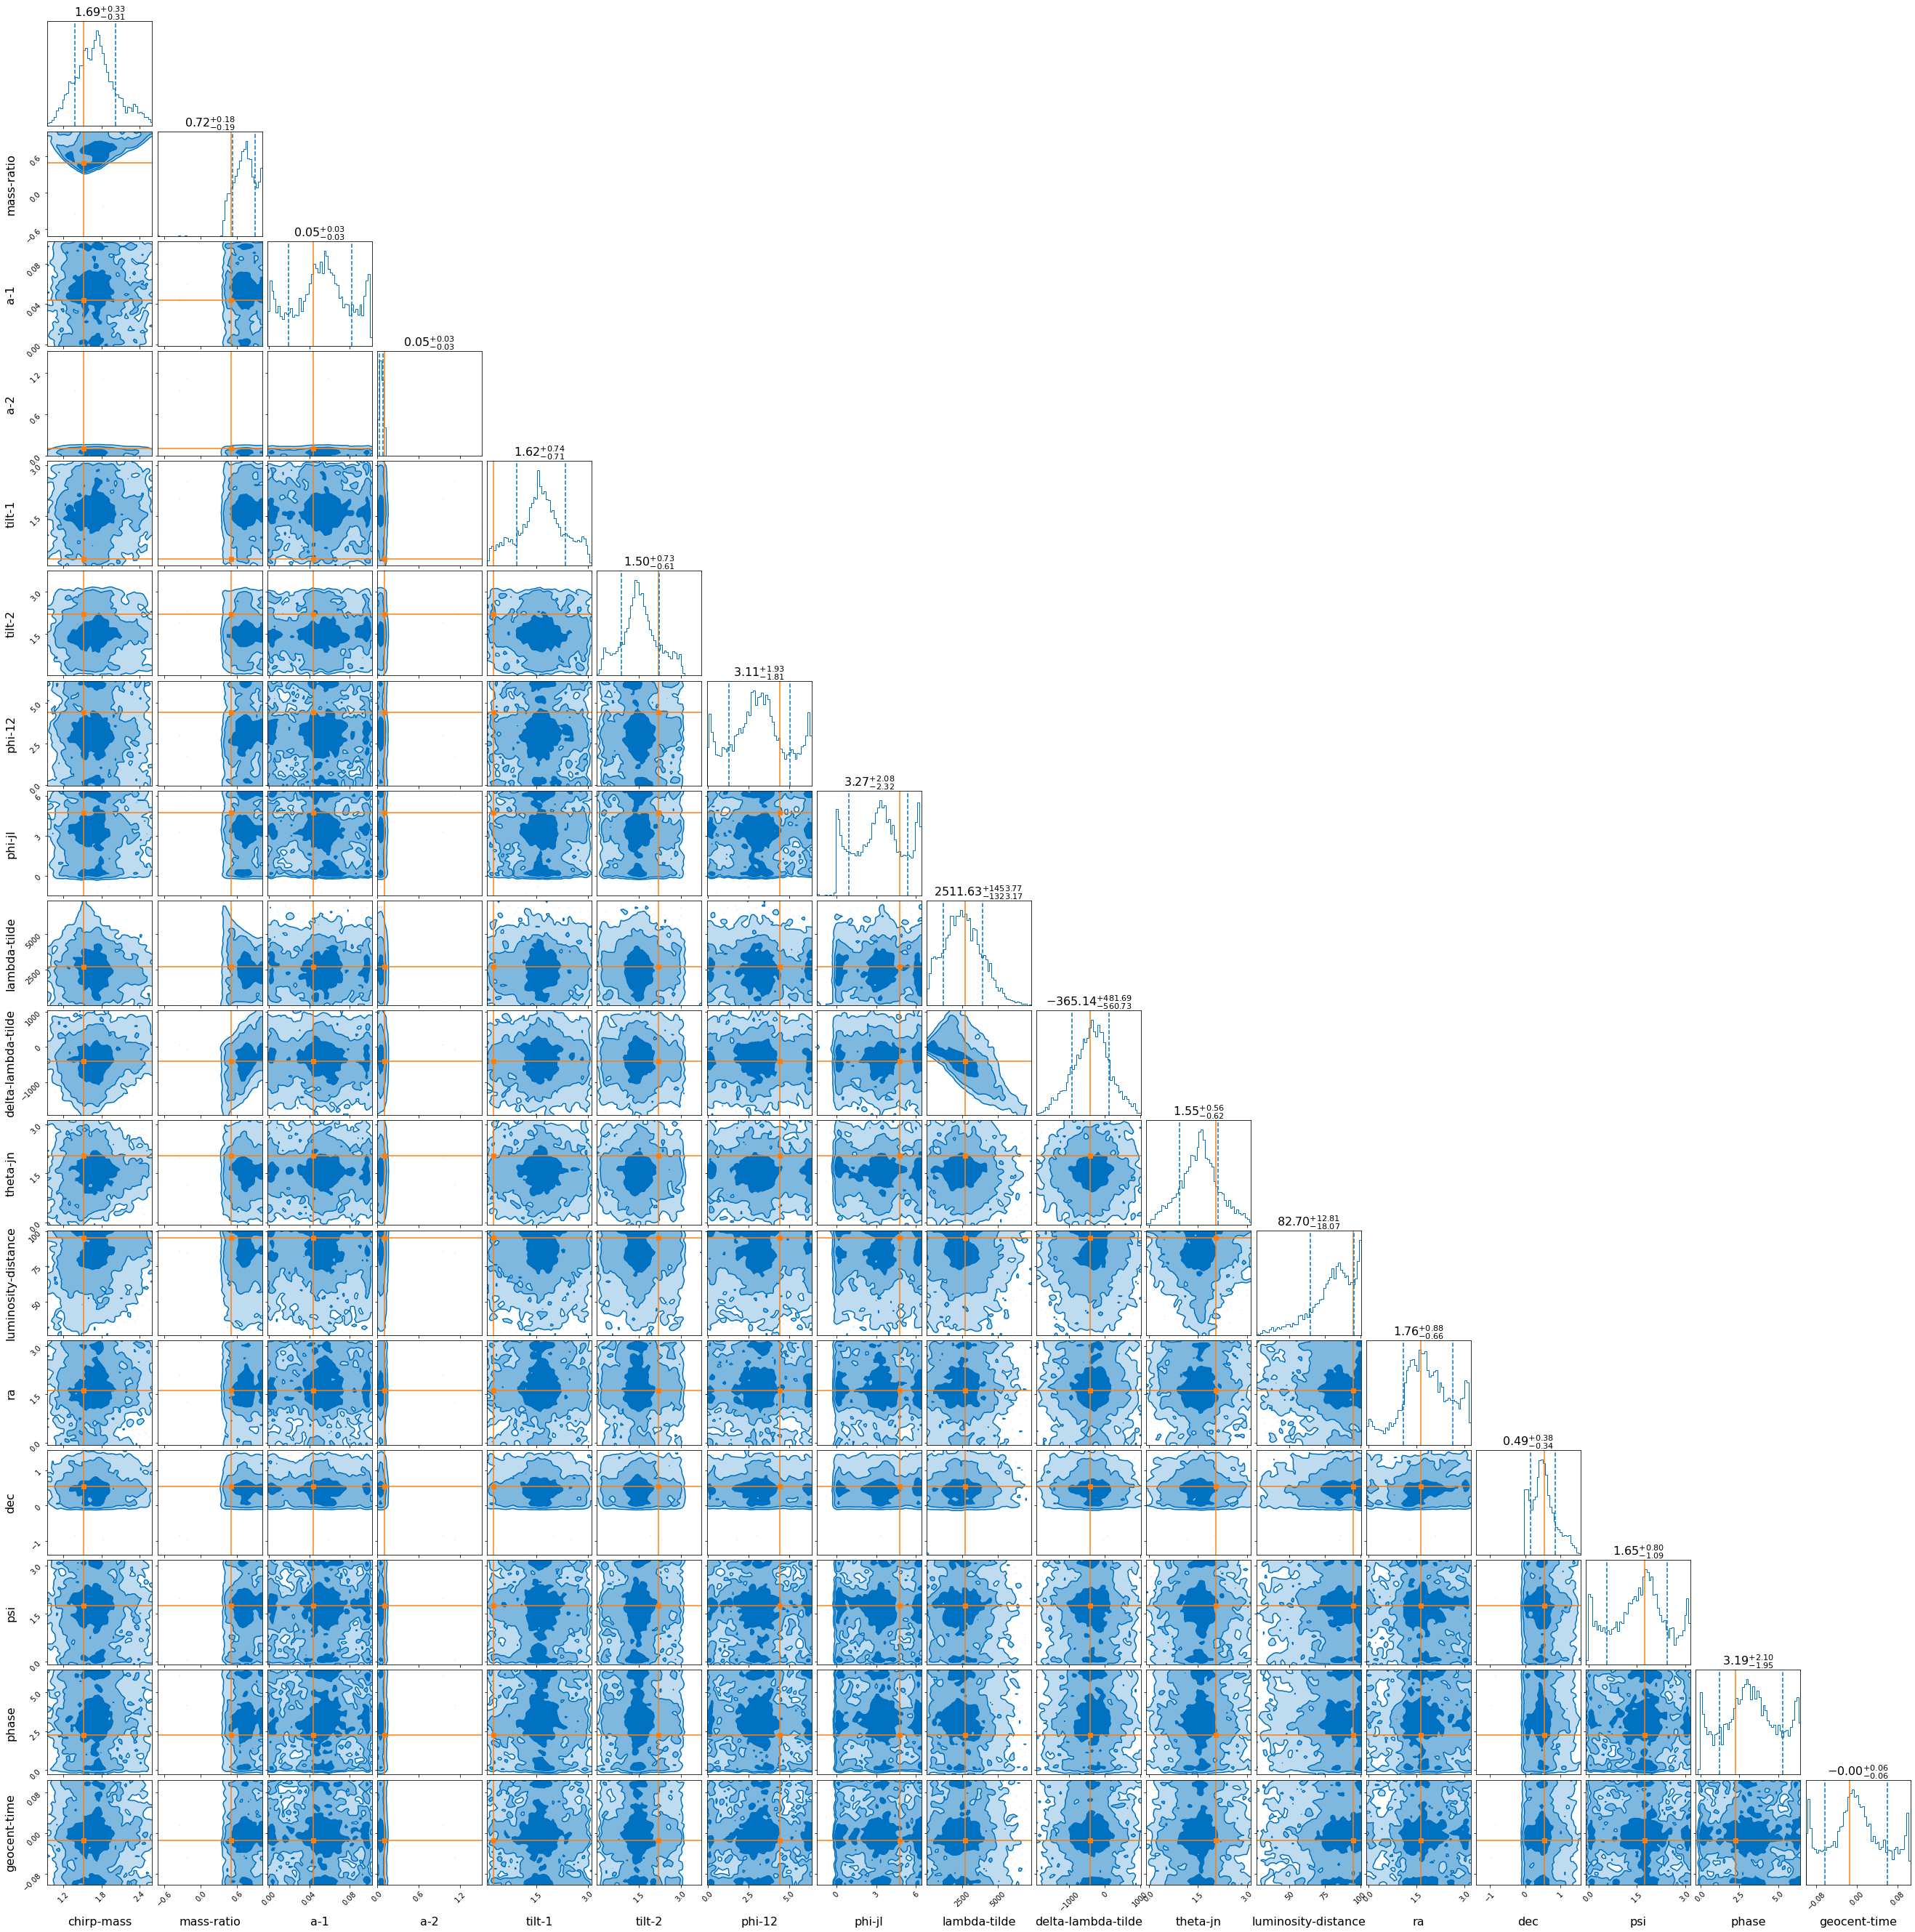

In [ ]:
fig = result.plot_corner(parameters=result.injection_parameters, save=False, filename = f"{config_path}/corner1.png")